# Tiling and Converting of Images and Masks

This notebook provides a workflow to process aerial imagery and create binary masks that can be used for training models for use in the BEAM tool. The functions work as follows:

- The tile_img function takes a large image and splits it into smaller tiles of a given size. This can help reduce the memory and computational requirements of processing the image.

- The tile_img_msk function does the same thing as the tile_img function, but also tiles the corresponding mask image that labels the pixels of interest in the original image. This can help preserve the spatial relationship between the image and the mask.

- The generate_mask function takes a raster file (a tif image) and a vector file (a shapefile or a geojson file) and creates a binary mask that matches the shape and size of the raster file. The binary mask has values of 0 or 1, where 1 indicates the pixels that belong to the polygons in the vector file. This can help create a ground truth mask for training or testing segmentation models.

- The save_masks function takes a list of raster files, a vector file, and a directory name and applies the generate_mask function to each raster file using the same vector file. It saves the resulting masks in the directory with the same names as the raster files. 

This notebook should be run before running the Training_and_inference notebook.

## 1. Install and Import Required Packages

In [1]:
# Import packages
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from shapely.ops import unary_union # previously used: cascaded_union
from shapely.geometry import mapping, Point, Polygon
import numpy as np
from PIL import Image
import os
from fastai.vision.all import *
from tqdm import tqdm
import cv2

c:\Users\hatho\mambaforge\envs\beam\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Set Paths for Images and Masks

If running on Google Colab, uncomment the next cell and mount Google Drive.

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Set directory containing images retrieve a list of all images contained. 
path = Path(f"C:/Users/hatho/OneDrive/Desktop/beam_imagery")
images_list = get_image_files(path/"images")

# Set directory of shapefile to be used to create mask
shp_path = f"{path}/labels/2020_labels.shp"

## 3. Define Functions

This function takes a list of images and a tile size as inputs. It creates subdirectories for image tiles and mask tiles in the output directory. It loads each image and its mask as numpy arrays and cuts them into smaller tiles of the same size before saving each tile as a .png file with the original image name and the tile coordinates.

In [4]:
def tile_img_msk(image_path, tile_size: int):
  """Tiles both images and masks and store them as .png-files"""
  for fn in tqdm(image_path):
    output_path = fn.parent.parent

    # Create directory for image tiles
    if not os.path.exists(output_path/'image_tiles'):
      os.makedirs(output_path/'image_tiles')
    # Create directory for mask tiles
    if not os.path.exists(output_path/f'mask_tiles'):
      os.makedirs(output_path/f'mask_tiles')

    # Load image and corresponding mask as numpy array and retrieve their shape
    img = np.array(PILImage.create(fn))
    msk_fn = str(fn).replace('images', 'untiled masks')
    msk = np.array(PILMask.create(msk_fn))
    x, y, _ = img.shape

    # Cut image and mask into tiles and store them as .png-files
    for i in range(x // tile_size):
      for j in range(y // tile_size):
        img_tile = img[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size]
        msk_tile = msk[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size]
        Image.fromarray(img_tile).save(f'{output_path}/image_tiles/{fn.name[:-4]}_{i}_{j}.png')
        Image.fromarray(msk_tile).save(f'{output_path}/mask_tiles/{fn.name[:-4]}_{i}_{j}.png')

This next function does the same but only for image files (it will not tile the corresponding mask). Set single = False for multiple images.

In [5]:
def tile_img(image_path, output_path, tile_size: int, single = None):
  """Tile image into smaller tiles and save them"""
  if single == False:
    for fn in tqdm(image_path):
      # Create directory
      if not os.path.exists(output_path):
        os.makedirs(output_path)

      # Load image as numpy array and retrieve its shape
      img = np.array(PILImage.create(fn))
      x, y, _ = img.shape

      # Cut image into tiles and store them as .png-files
      for i in range(x//tile_size):
        for j in range(y//tile_size):
          img_tile = img[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size]
          Image.fromarray(img_tile).save(f'{output_path}/{fn.name[:-4]}/{fn.name[:-4]}_{i}_{j}.png')

  if single == True:
    # Create directory
    if not os.path.exists(output_path):
      os.makedirs(output_path)

    # Load image as numpy array and retrieve its shape
    img = np.array(PILImage.create(image_path))
    x, y, _ = img.shape

    # Cut image into tiles and store them as .png-files
    fn = image_path.split("/")[-1][:-4]
    for i in range(x//tile_size):
      for j in range(y//tile_size):
        img_tile = img[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
        Image.fromarray(img_tile).save(f'{output_path}/{fn}/{fn}_{i}_{j}.png')

The next two functions work together to save binary masks from vector files. The first function, `generate_mask`, takes four arguments: `raster_path`, `shape_path`, `output_path`, and `file_name`. It generates a binary mask from a vector file (shp or geojson) that matches the shape and size of a raster file (tif). It can either save the mask as a png file in the output path with the given file name, or return the mask as an array.

The second function, `save_masks`, takes three arguments: `images`, `mask`, and `maskdir`. It loops over a list of raster files (images) and applies the `generate_mask` function to each file using a vector file (mask) as the source of polygons. It saves the masks in a directory (maskdir) with the same names as the raster files.

In [6]:
def generate_mask(raster_path, shape_path, output_path = None, file_name = None):
    """Function that generates a binary mask from a vector file (shp or geojson)
    raster_path = path to the .tif;
    shape_path = path to the shapefile or GeoJson.
    output_path = Path to save the binary mask.
    file_name = Name of the file."""
    
    # Load image
    with rasterio.open(raster_path, "r") as src:
        raster_img = src.read()
        raster_meta = src.meta
    
    # Load corresponding shapefile containing marked pixels
    train_df = gpd.read_file(shape_path)
    
    # Verify CRS and print warning message before converting if the two don't match
    if train_df.crs != src.crs:
      print(f'Raster CRS: {src.crs}, Vector CRS: {train_df.crs}.\n Convert vector and raster to the same CRS.')
      # update CRS to match the raster
      train_df = train_df.to_crs(src.crs)
  
        
    # Generate the mask
    def poly_from_utm(polygon, transform):
        poly_pts = []
        poly = unary_union(polygon) # previously used: cascaded_union(polygon)
        for i in np.array(poly.exterior.coords):
            poly_pts.append( ~ transform * tuple(i))
        new_poly = Polygon(poly_pts)
        return new_poly
    
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_df.iterrows():
        if row['geometry'].geom_type == 'MultiPolygon':
            for p in row['geometry'].geoms: # iterate over polygons within a MultiPolygon
                poly = poly_from_utm(p, src.meta['transform'])
                poly_shp.append(poly)
        elif row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            # raise an error or skip the object
            raise TypeError("Invalid geometry type")
    
    if len(poly_shp) > 0:
        mask = rasterize(shapes=poly_shp, out_shape=im_size)
    else:
        mask = np.zeros(im_size)
    
    # Save or show mask
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)    
    mask = mask.astype('uint8')    
    bin_mask_meta = src.meta.copy()
    bin_mask_meta.update({'count': 1})
    if (output_path != None and file_name != None):
        os.chdir(output_path)
        with rasterio.open(file_name, 'w', **bin_mask_meta) as dst:
            dst.write(mask * 255, 1) # Change 255 to 1 if classes need to be 0 and 1
    else:
        return mask


def save_masks(images, mask, maskdir):
    if not os.path.exists(maskdir):
        os.makedirs(maskdir)
    for image in tqdm(images):
        if image.name.endswith(('.TIF', '.tif')):
            shapes = image.name
            generate_mask(image, mask, maskdir, shapes)

 


These two functions determine the ratio of pixels belonging to buildings compared to non-buildings for each image.

In [7]:
def informal_pixels_from_directory(directory):
  """Determine for each file in a directory, how many of its pixels are part
  of an informal settlement. 
  """
  output_dict = {}
  for file in os.listdir(directory):
      try:
          mask = rasterio.open(os.path.join(directory, file))
          mask = (mask).read()
          settlement_pixels = np.count_nonzero(mask == 1)
          total_pixels = mask.size
          settlement_share = settlement_pixels / total_pixels
          output_dict[file] = settlement_share
      except:
          print(f'File {file} encountered an error.')
          continue
  return output_dict

def informal_pixels_from_file(file):
  """Determine for a single file how many of its pixels are part of an informal settlement."""
  output_dict = {}
  mask = rasterio.open(file)
  mask = mask.read()
  settlement_pixels = np.count_nonzero(mask == 1)
  total_pixels = mask.size
  settlement_share = settlement_pixels / total_pixels
  return settlement_share

## 4. Tile Images and Masks

### 4.1. Visualise Mask

This is a quick plot to visualise the vector mask.

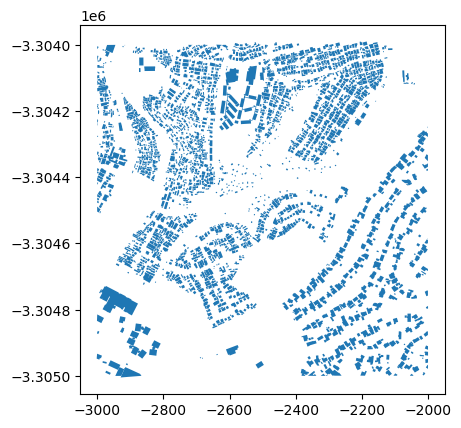

In [8]:
mask_plot = gpd.read_file(shp_path)
mask_plot["geometry"].plot();

In [9]:
print(f'Number of images: {len(images_list)}')
print(images_list[0])

Number of images: 1
C:\Users\hatho\OneDrive\Desktop\beam_imagery\images\2020_RGB_10cm_CA_065.tif


Here we create masks from vector labels that correspond to source images.

In [10]:
# Create masks corresponding to selected images
save_masks(images_list, shp_path, path/f'untiled masks')

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:11<00:00, 11.22s/it]


And here we tile the images and masks for training. 

In [11]:
# Tile images and masks with a stride of 0 pixels
tile_size = 512
tile_img_msk(images_list, tile_size)

  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\hatho\mambaforge\envs\beam\lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1/1 [01:57<00:00, 117.45s/it]
